From the original full BindingDB database, we extracted a smaller, more manageable dataset by selecting only ligand-target pairs studied on viral organisms associated with sexually transmitted diseases, such as Human Immunodeficiency Virus (HIV). This subset is saved in the same `.tsv` file format as the original database.

For more details on the extraction process, refer to [`./src/data/std_extraction.ipynb`](./src/data/std_extraction.ipynb).


In [1]:
#import libraries and scripts

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils, general_utils

In [5]:
#read the std database

df = pd.read_csv('BindingSTD.tsv', sep = '\t', on_bad_lines='skip', low_memory = False)
print(df.shape)

(30156, 86)


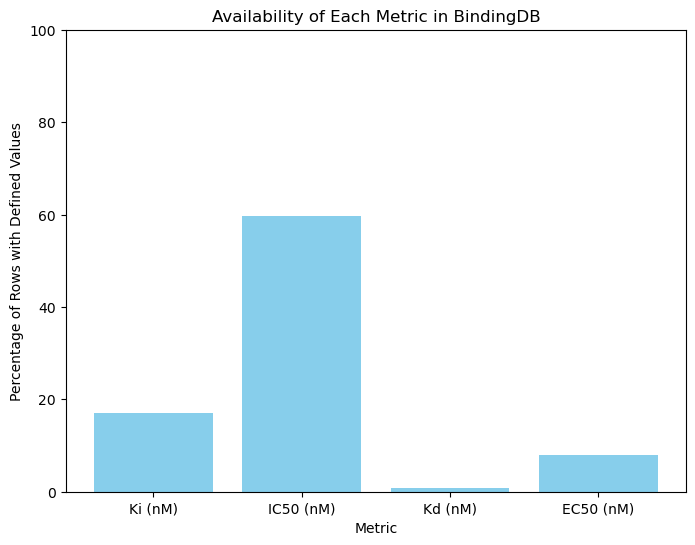

In [6]:
evaluation_utils.plot_metric_availability(df)

We observe that IC50 is given in more than 50% of the rows, while the other metric are less represented. We will select only rows with this metric for our analyses

In [8]:
df = data_utils.select_metric(df, 'IC50 (nM)')
df = data_utils.clean_na_columns(df)
print(df.shape)

(18026, 27)


Now, we can try and observe the distribution of our IC50 parameter. Typically, IC50 values in the low nanomolar (nM) range, such as 1–100 nM, are considered very potent. The range of IC50 values can vary widely depending on the specific biological system, target, and experimental conditions.
Compounds with IC50 values in the 100 nM – 1 µM (1000 nM) range are moderately potent. Above 1 µM (1000 nM) are the drugs that are considered to have a lower affinity for their target. When we have very high IC50 values, in the range of several µM (micromolar) to mM (millimolar), the compound is considered not effective at binding its target and often must be optimized for potency.

In [16]:
df['IC50 (nM)'].describe()

count    1.802600e+04
mean     3.920599e+04
std      5.866093e+05
min      1.000000e-03
25%      3.500000e+01
50%      4.400000e+02
75%      5.900000e+03
max      3.815000e+07
Name: IC50 (nM), dtype: float64

<Axes: xlabel='IC50 (nM)'>

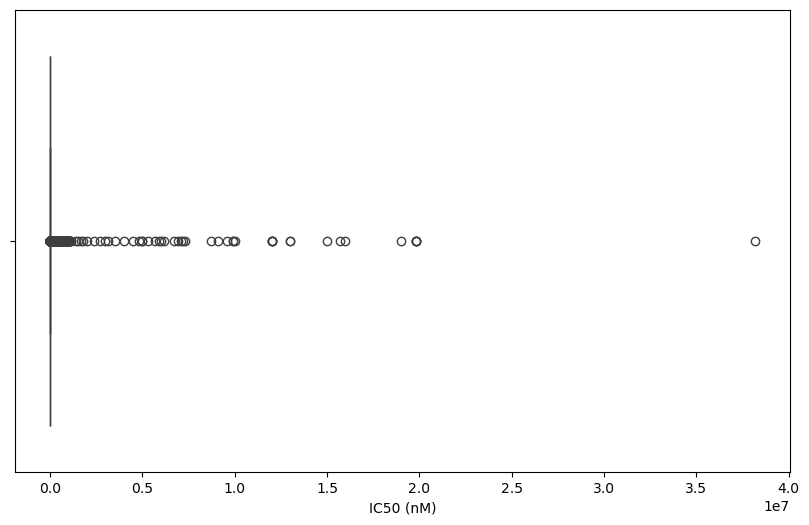

In [18]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x=df['IC50 (nM)'])

We can see that our data spans a large range, therefore in order to be able to properly see the smaller values and show a more interpretable visualization we can use a logarithmic compression. This log-log transformation can reveal patterns across data that spans several orders of magnitude, both in terms of IC50 values (x-axis) and counts (y-axis).


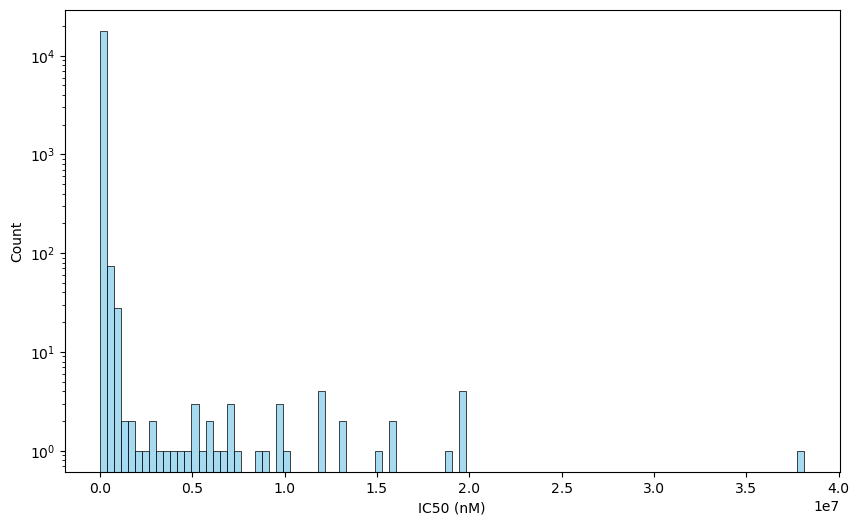

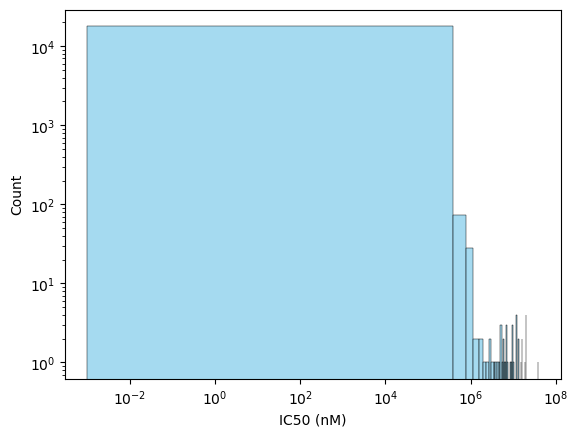

In [29]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the histogram using Seaborn with a logarithmic scale
sns.histplot(df['IC50 (nM)'], bins=100, kde=False, color='skyblue')

# Set the y-axis only to a logarithmic scale
#plt.xscale('log')
plt.yscale('log')
plt.show()

#Set both x-axis and y-axis to a logarithmic scale (bins = 100 instructs the histogram to split the data in 100 equally spaced bins,
# regarding the range of our parameter. 
# We will have smaller bins as we go towards the right, as larger numbers will be more compressed)
sns.histplot(df['IC50 (nM)'], bins=100, kde=False, color='skyblue')
plt.xscale('log')
plt.yscale('log')